# Audio classification using convolutional neural networks

You are the leader of a group of climate scientists who are concerned about the planet's dwindling rain forests. The world loses up to 10 million acres of old-growth rain forests each year, much of it due to illegal logging. Deforestation from this and other causes accounts for about 10% of global carbon emissions. Your team plans to convert thousands of discarded smart phones into solar-powered listening devices and position them througout the Amazon to transmit alerts in response to the sounds of chainsaws and truck engines. You need software to install on these phones that uses artificial intelligence (AI) to identify such sounds in real time. And you need it fast, because climate change won't wait.

State-of-the-art audio classification can be performed by converting audio streams into [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which provide visual representations of spectrums of frequencies as they vary over time, and classifying the spectrograms using [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs). The spectrograms below were generated from WAV files with chainsaw sounds in the foreground and rainforest sounds in the background. Let's use Keras to build a CNN that can identify the tell-tale sounds of logging operations and distinguish them from ambient sounds such as wildlife and thunderstorms.

![](Images/spectrograms.png)

This notebook was inspired by the [Rainforest Connection](https://rfcx.org/), which uses recycled Android phones and a TensorFlow model similar to the one built here to monitor rain forests for sounds indicative of illegal activity. For more information, see [The fight against illegal deforestation with TensorFlow](https://blog.google/technology/ai/fight-against-illegal-deforestation-tensorflow/) in the Google AI blog. It is just one example of how AI is making the world a better place.

## Generate spectrograms

The "Sounds" directory contains subdirectories named "background," "chainsaw," "engine," and "storm." Each subdirectory contains 100 WAV files. The WAV files in the "background" directory contain rainforest background noises only, while the files in the other subdirectories include the sounds of chainsaws, engines, and thunderstorms overlaid on the background noises. These WAV files were generated by using a soundscape-synthesis package named [Scaper](https://pypi.org/project/scaper/) to combine sounds in the public [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset with rainforest sounds obtained from YouTube.

The first step is to load the WAV files, use a Python package named [Librosa](https://librosa.org/) to generate spectrogram images from them, load the spectrograms into memory, and prepare them for use in training a CNN. To aid in this process, we'll define a pair of helper functions for creating spectrograms from WAV files and converting all the WAV files in a specified directory into spectrograms.

In [1]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
%matplotlib inline

def create_spectrogram(infile, outfile):
    audio, sr = librosa.load(infile, res_type='kaiser_fast')
    ms = librosa.feature.melspectrogram(audio, sr=sr, n_mels=128)
    log_ms = librosa.power_to_db(ms, ref=np.max)

    fig = plt.figure(figsize=[1, 1])
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.axis('tight')
    plt.margins(0)

    librosa.display.specshow(log_ms, sr=sr)
    fig.savefig(outfile, dpi=224, pad_inches=0)
    plt.close(fig)
    plt.close('all')
    
    del audio, ms, log_ms, ax, fig
    
def create_pngs_from_wavs(inpath, outpath):
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    dir = os.listdir(inpath)

    for i, file in enumerate(dir):
        infile = os.path.join(inpath, file)
        outfile = os.path.join(outpath, file.replace('.wav', '.png'))
        create_spectrogram(infile, outfile)

Create PNG files containing spectrograms from all the WAV files in the "Sounds/background" directory.

In [2]:
create_pngs_from_wavs('Sounds/background', 'Spectrograms/background')

Create PNG files containing spectrograms from all the WAV files in the "Sounds/chainsaw" directory.

In [3]:
create_pngs_from_wavs('Sounds/chainsaw', 'Spectrograms/chainsaw')

Create PNG files containing spectrograms from all the WAV files in the "Sounds/engine" directory.

In [4]:
create_pngs_from_wavs('Sounds/engine', 'Spectrograms/engine')

Create PNG files containing spectrograms from all the WAV files in the "Sounds/storm" directory.

In [5]:
create_pngs_from_wavs('Sounds/storm', 'Spectrograms/storm')

Define two new helper functions for loading and displaying spectrograms and declare two Python lists — one to store spectrogram images, and another to store class labels.

In [6]:
from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

Load the background spectrogram images, add them to the list named `x`, and label them with 0s.

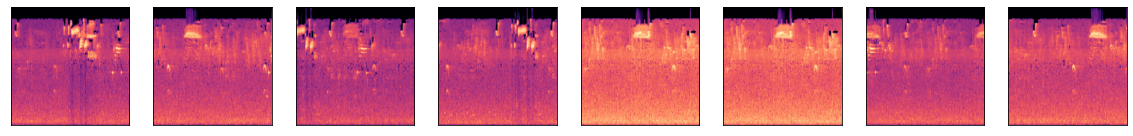

In [7]:
images, labels = load_images_from_path('Spectrograms/background', 0)
show_images(images)
    
x += images
y += labels

Load the chainsaw spectrogram images, add them to the list named `x`, and label them with 1s.

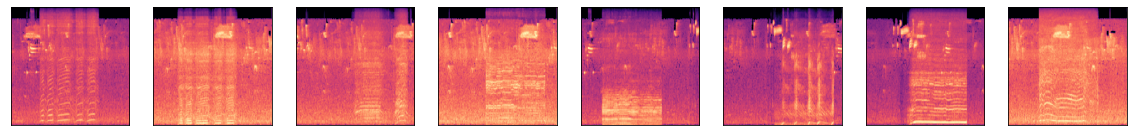

In [8]:
images, labels = load_images_from_path('Spectrograms/chainsaw', 1)
show_images(images)
    
x += images
y += labels

Load the engine spectrogram images, add them to the list named `x`, and label them with 2s.

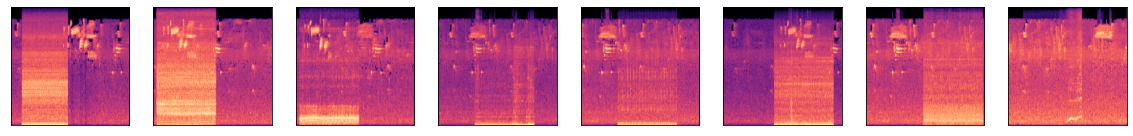

In [9]:
images, labels = load_images_from_path('Spectrograms/engine', 2)
show_images(images)
    
x += images
y += labels

Load the storm spectrogram images, add them to the list named `x`, and label them with 3s.

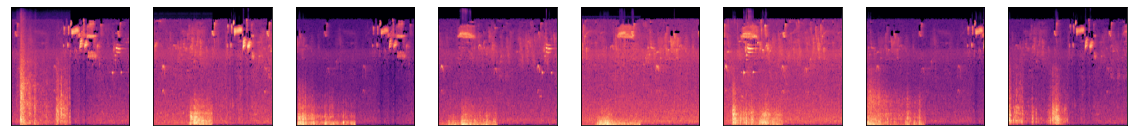

In [10]:
images, labels = load_images_from_path('Spectrograms/storm', 3)
show_images(images)
    
x += images
y += labels

Split the images and labels into two datasets — one for training, and one for testing. Then divide the pixel values by 255 and one-hot-encode the labels using Keras's [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function) function.

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

## Build and train a CNN

State-of-the-art image classification typically isn't done with traditional neural networks. Rather, it is performed with convolutional neural networks that use [convolution layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) to extract features from images and [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) to downsize images so features can be detected at various resolutions. The next task is to build a CNN containing a series of convolution and pooling layers for feature extraction, a pair of fully connected layers for classification, and a `softmax` layer that outputs probabilities for each class, and to train it with spectrogram images and labels. Start by defining the CNN.

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

Train the CNN for 20 epochs and save the `history` object returned by `fit` in a local variable.

In [13]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=20)

Epoch 1/20
28/28 [==============================] - 16s 278ms/step - loss: 1.4129 - accuracy: 0.3201 - val_loss: 1.3738 - val_accuracy: 0.2500
Epoch 2/20
28/28 [==============================] - 7s 263ms/step - loss: 1.2901 - accuracy: 0.3471 - val_loss: 0.8250 - val_accuracy: 0.6083
Epoch 3/20
28/28 [==============================] - 7s 265ms/step - loss: 0.7843 - accuracy: 0.5997 - val_loss: 0.6756 - val_accuracy: 0.6250
Epoch 4/20
28/28 [==============================] - 7s 263ms/step - loss: 0.6036 - accuracy: 0.7106 - val_loss: 0.6024 - val_accuracy: 0.7000
Epoch 5/20
28/28 [==============================] - 7s 261ms/step - loss: 0.4915 - accuracy: 0.7783 - val_loss: 0.5588 - val_accuracy: 0.6917
Epoch 6/20
28/28 [==============================] - 7s 261ms/step - loss: 0.4364 - accuracy: 0.7611 - val_loss: 0.4821 - val_accuracy: 0.7667
Epoch 7/20
28/28 [==============================] - 7s 261ms/step - loss: 0.2878 - accuracy: 0.8653 - val_loss: 0.4281 - val_accuracy: 0.8333
Epoch

Plot the training and validation accuracy.

[]

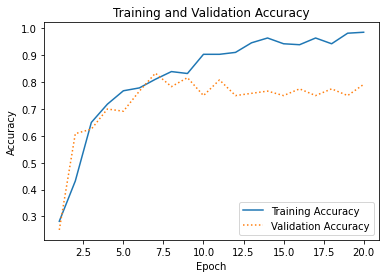

In [14]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

The accuracy is decent given that the network was trained with just 280 images, but it might be possible to achieve higher accuracy by employing transfer learning.

## Use transfer learning to improve accuracy

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated CNNs trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. Many pretrained CNNs are available in the public domain, and several are included with Keras. Let's use [`MobileNetV2`](https://keras.io/api/applications/mobilenet/), a pretrained CNN from Google that is optimized for mobile devices, to extract features from spectrogram images.

> `MobileNetV2` requires less processing power and has a smaller memory footprint than CNNs such as `ResNet50V2`. That's why it is ideal for mobile devices. You can learn more about it in the [Google AI blog](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html).

Start by calling Keras's [MobileNetV2](https://keras.io/api/applications/mobilenet/) function to instantiate `MobileNetV2` without the classification layers. Use the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input) function for `MobileNet` networks to preprocess the training and testing images. Then run both datasets through `MobileNetV2` to extract features.

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)

Define a neural network to classify features extracted by `MobileNetV2`.

In [16]:
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train the network with features extracted by `MobileNetV2`.

In [17]:
hist = model.fit(train_features, y_train_encoded, validation_data=(test_features, y_test_encoded), batch_size=10, epochs=20)

Epoch 1/20
28/28 [==============================] - 3s 73ms/step - loss: 20.0997 - accuracy: 0.4650 - val_loss: 1.7893 - val_accuracy: 0.8667
Epoch 2/20
28/28 [==============================] - 2s 67ms/step - loss: 1.7130 - accuracy: 0.8832 - val_loss: 0.4821 - val_accuracy: 0.9500
Epoch 3/20
28/28 [==============================] - 2s 68ms/step - loss: 0.3408 - accuracy: 0.9637 - val_loss: 2.2358 - val_accuracy: 0.8833
Epoch 4/20
28/28 [==============================] - 2s 68ms/step - loss: 0.8100 - accuracy: 0.9737 - val_loss: 3.6697 - val_accuracy: 0.7667
Epoch 5/20
28/28 [==============================] - 2s 68ms/step - loss: 0.8047 - accuracy: 0.9230 - val_loss: 0.9756 - val_accuracy: 0.9417
Epoch 6/20
28/28 [==============================] - 2s 68ms/step - loss: 0.5087 - accuracy: 0.9652 - val_loss: 1.2147 - val_accuracy: 0.9250
Epoch 7/20
28/28 [==============================] - 2s 67ms/step - loss: 0.1303 - accuracy: 0.9866 - val_loss: 3.2798 - val_accuracy: 0.8250
Epoch 8/20
2

Plot the training and validation accuracy.

[]

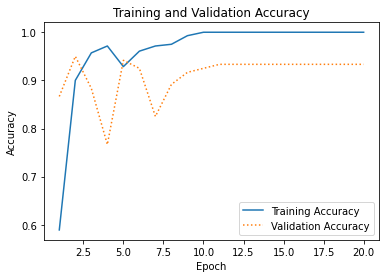

In [18]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run the test images through the network and use a confusion matrix to assess the results.

Text(89.18, 0.5, 'Actual label')

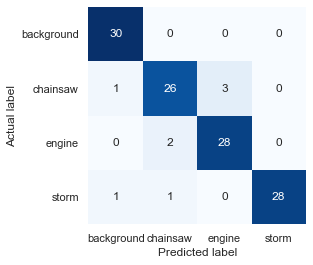

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(test_features)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['background', 'chainsaw', 'engine', 'storm']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

The network is pretty adept at identifying clips that don't contain the sounds of chainsaw or engines. It sometimes confuses chainsaw sounds and engine sounds, but that's OK, because the presence of either might indicate illicit activity in a rain forest.

## Test with unrelated WAV files

The "Sounds" directory has a subdirectory named "samples" containing WAV files that the CNN was neither trained nor tested with. The WAV files bear no relation to the samples used for training and testing; they were extracted from a YouTube video documenting Brazil's efforts to curb illegal logging. Let's use the model trained in the previous exercise to analyze these files for sounds of logging activity. Start by creating a spectrogram from the first sample WAV file, which contains audio of loggers cutting down trees in the Amazon.

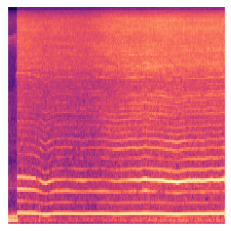

In [20]:
create_spectrogram('Sounds/samples/sample1.wav', 'Spectrograms/sample1.png')

x = image.load_img('Spectrograms/sample1.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the spectrogram image, pass it to `MobileNetV2` for feature extraction, and classify the features.

In [21]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

background: 7.598667222549937e-18
chainsaw: 0.9976465106010437
engine: 0.0023535038344562054
storm: 1.4584992285085474e-12


Create a spectrogram from a WAV file that includes the sounds of a logging truck rumbling through the rain forest.

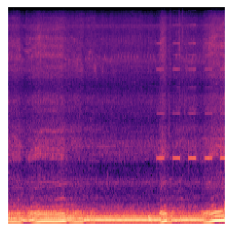

In [22]:
create_spectrogram('Sounds/samples/sample2.wav', 'Spectrograms/sample2.png')

x = image.load_img('Spectrograms/sample2.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the spectrogram image, pass it to `MobileNetV2` for feature extraction, and classify the features.

In [23]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

background: 2.3750764348220024e-35
chainsaw: 2.4471756264938324e-17
engine: 1.0
storm: 3.810615479636349e-24


If the network got either of the samples wrong, try training it again with the output from `MobileNetV2`. Remember that a neural network will train differently every time, in part because Keras initializes the weights and biases with small random values. In the real world, data scientists often train a neural network 20 or more times and average the results to quantify its accuracy.